In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
ds=xr.open_dataset('cm1out_000005.nc')

In [3]:
num_x = ds.ni
num_y = ds.nj
num_z = ds.nk

dx = ds['xh']*units('m')
dy = ds['yh']*units('m')
dz = ds['zh']*units('m')

u10 = ds['u10']
v10 = ds['v10']
theta = ds['th']
press = ds['prs']
wv = ds['qv']
wc = ds['qc']
wr = ds['qr']
u = ds['u']
v = ds['v']
w = ds['w']

x_space = 31.25*units('m')
y_space = 31.25*units('m')
z_space = 15.625*units('m')

In [4]:
lev = 0
u = u.isel(nk=lev,time=0)
v = v.isel(nk=lev,time=0)
w = w.isel(nk=lev,time=0)
theta = theta.isel(nk=lev,time=0)

In [5]:
wspd = mpcalc.wind_speed(u, v)

In [6]:
np.where(wspd==wspd.max())

(array([493]), array([1004]))

In [7]:
def tilting_term(dwdy, dudz, dwdx, dvdz):
    return(dwdy*dudz + dwdx*dvdz)

In [8]:
tilting_term(4, 5, 6, 7)

62

In [9]:
dz[0] # z direction grid delta

<xarray.DataArray 'zh' ()>
<Quantity(7.8125, 'meter')>

In [10]:
dudz = mpcalc.first_derivative(u, delta=dz[1]-dz[0])
dvdz = mpcalc.first_derivative(v, delta=dz[1]-dz[0])
dwdy = mpcalc.first_derivative(w, delta=dy[1]-dy[0])
dwdx = mpcalc.first_derivative(w, delta=dx[1]-dx[0])

In [11]:
tilting_term = tilting_term(dwdy,dudz,dwdy,dvdz)

In [12]:
dz[1]-dz[0]

<xarray.DataArray 'zh' ()>
<Quantity(15.625, 'meter')>

In [13]:
dx[1]-dx[0] # is this what should be used in the vorticity calculations instead of what dx[0]?

<xarray.DataArray 'xh' ()>
<Quantity(31.25, 'meter')>

In [14]:
np.where(wspd==wspd.max()) # y x order

(array([493]), array([1004]))

In [15]:
tilting_term.min(), tilting_term.max()

(-0.28875595 <Unit('1 / second ** 2')>, 0.16717237 <Unit('1 / second ** 2')>)

In [16]:
rel_vort = mpcalc.vorticity(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0])

/tmp/ipykernel_2370531/36216527.py:1: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  rel_vort = mpcalc.vorticity(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0])


In [17]:
rel_vort.min(), rel_vort.max()

(<xarray.DataArray ()>
 <Quantity(-0.9537445902824402, '1 / second')>
 Coordinates:
     time     datetime64[ns] 2000-01-01T00:00:04,
 <xarray.DataArray ()>
 <Quantity(1.6693997383117676, '1 / second')>
 Coordinates:
     time     datetime64[ns] 2000-01-01T00:00:04)

In [18]:
div = mpcalc.divergence(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0])

/tmp/ipykernel_2370531/3623114684.py:1: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mpcalc.divergence(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0])


In [19]:
stretching_term = rel_vort*div

In [20]:
stretching_term.min(), stretching_term.max()

(<xarray.DataArray ()>
 <Quantity(-0.8163394927978516, '1 / second ** 2')>
 Coordinates:
     time     datetime64[ns] 2000-01-01T00:00:04,
 <xarray.DataArray ()>
 <Quantity(0.254661500453949, '1 / second ** 2')>
 Coordinates:
     time     datetime64[ns] 2000-01-01T00:00:04)

Text(0.5, 1.0, 'Tilting Term (black), Stretching Term (blue), and Relative Vorticity (white)')

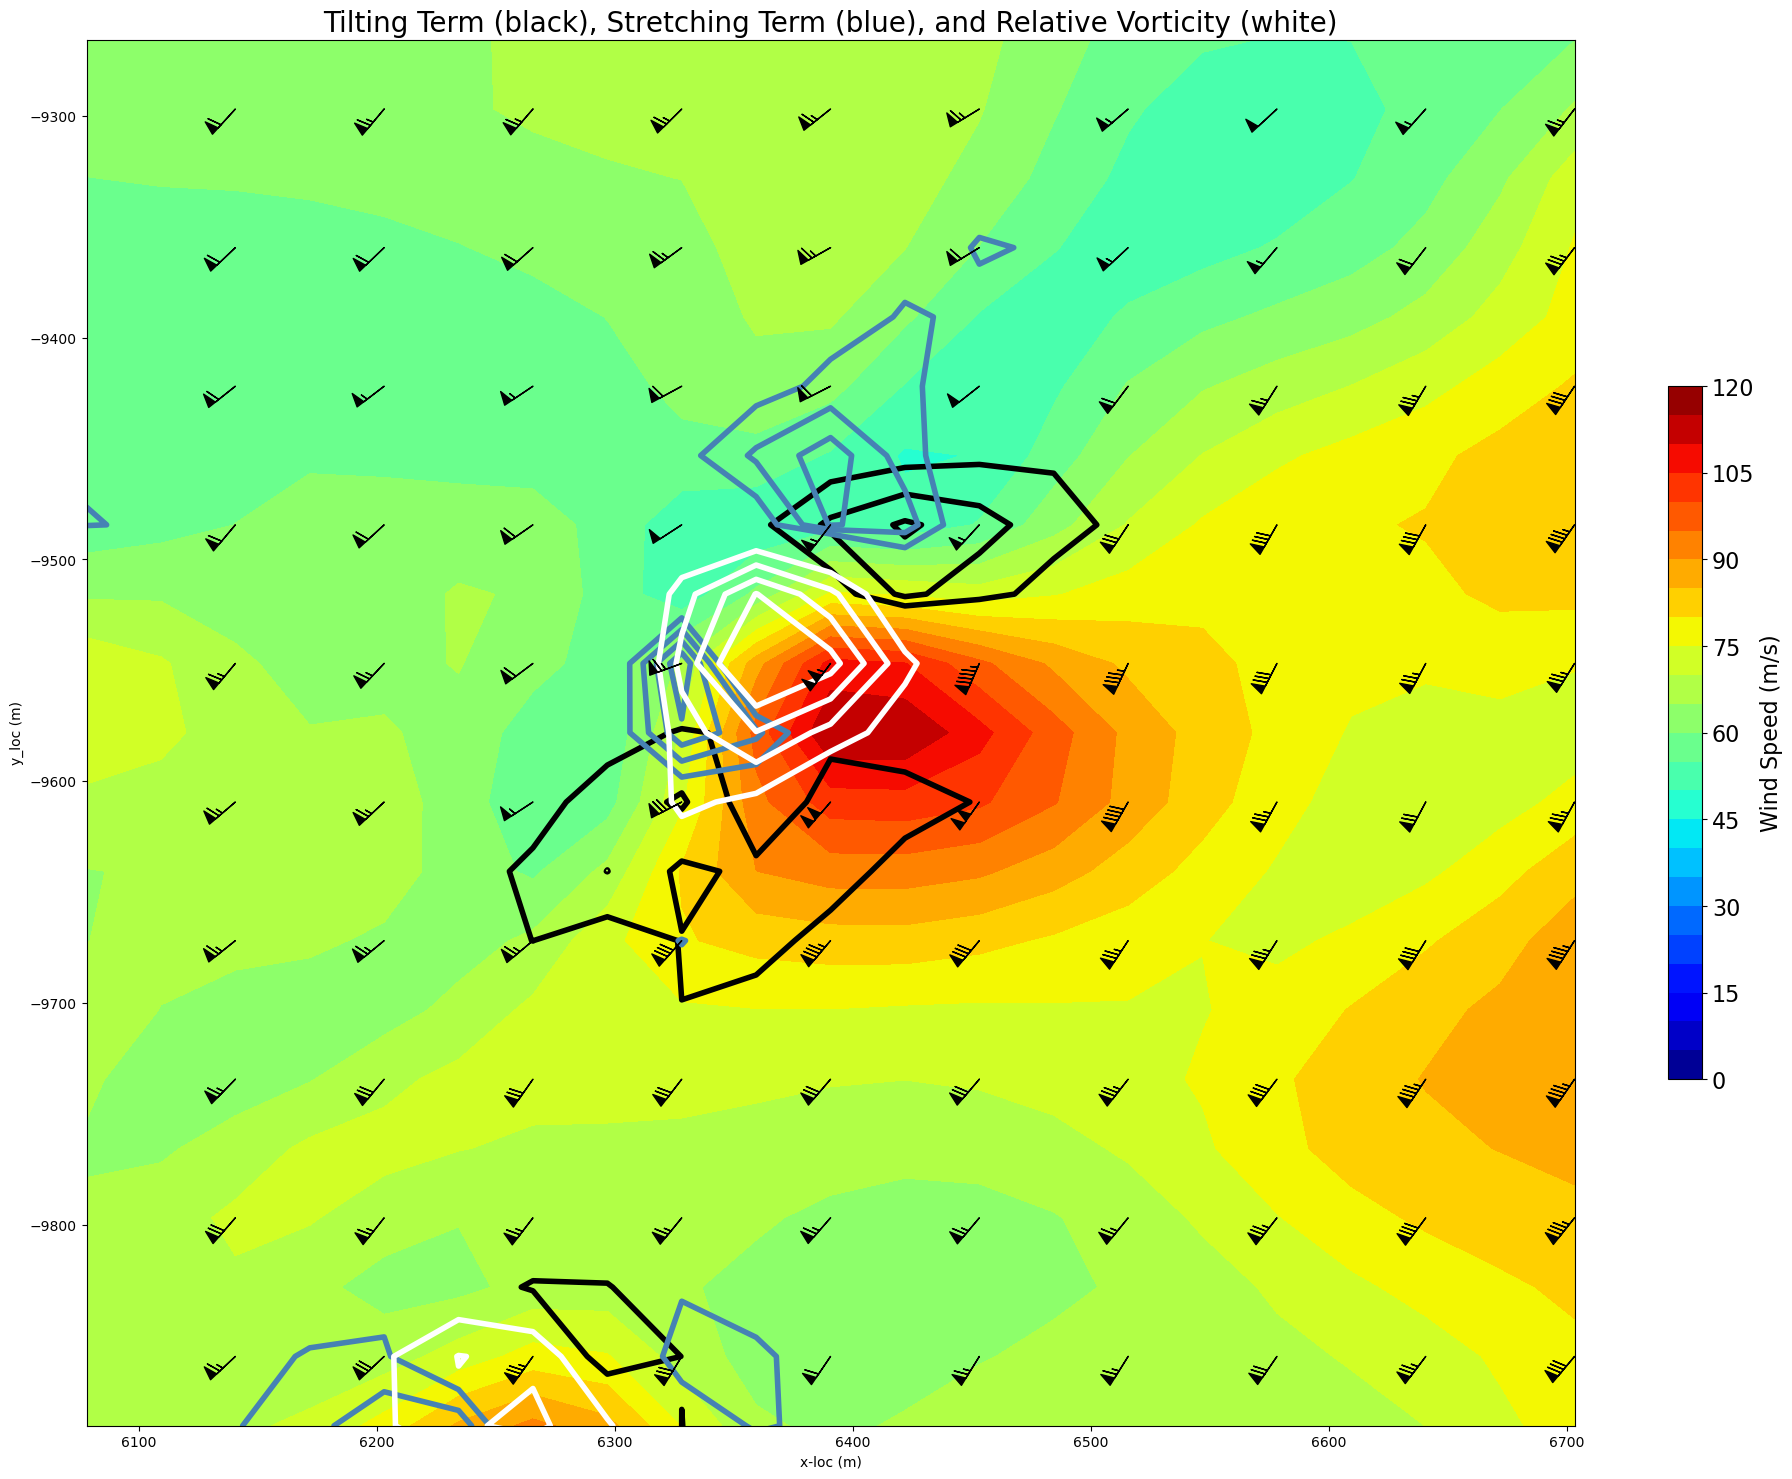

In [37]:
fig = plt.figure(figsize=(24,18))
ax=plt.subplot(1,1,1)
# 50 x 50 gridpoint plot surrounding the index location of wind speed maximum
ax.set_xlim(dx.isel(ni=994), dx.isel(ni=1014)) # 10 below 1004 and 10 above 1004
ax.set_ylim(dy.isel(nj=483), dy.isel(nj=503)) # 10 below 493 and 10 above 493
CL1 = ax.contour(dx, dy, tilting_term, levels=np.arange(.02, .2, .05), colors='k', linewidths=4)
CL2 = ax.contour(dx, dy, stretching_term, levels=np.arange(.02, .27, .05), colors='steelblue', linewidths=4)
CL3 = ax.contour(dx, dy, rel_vort, levels=np.arange(.5, 1.5, .25), colors='white', linewidths=4)
skip=2
CF = ax.contourf(dx, dy, wspd, levels=np.arange(0, 125, 5), cmap='jet')
ax.barbs(dx[::skip], dy[::skip], u[::skip,::skip].values, v[::skip,::skip].values, zorder=3)
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Wind Speed (m/s)",fontsize=16)
ax.set_xlabel('x-loc (m)')
ax.set_ylabel('y_loc (m)')
ax.set_title('Tilting Term (black), Stretching Term (blue), and Relative Vorticity (white)', fontsize=20)